# Test model mismatch hypothesis on Glaze task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ssm

from numpy.random import default_rng
from scipy.special import logit, expit
from ssm.util import find_permutation

from tasks import GlazeTask
from glazemodel import GlazeAgent, GlazeModel

In [2]:
rng = default_rng(999)

## Create synthetic data with uncorrelated stimuli

In [3]:
n_trials = 5000
h_true = 0.5
noise_true = 1.0

task = GlazeTask(hazard_rate=h_true, noise=noise_true, rng=rng)
s, x = task.sample_trials(n_trials)

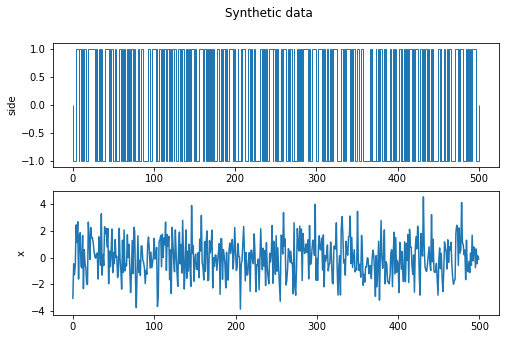

In [4]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(2, 1, figsize=(8, 5))

ax[0].stairs(s[idx])
ax[0].set_ylabel('side')

ax[1].plot(x[idx])
ax[1].set_ylabel('x')

fig.suptitle('Synthetic data');

## Run agent with incorrect hazard rate on data

In [5]:
# Incorrect value for hazard rate
h_agent = 0.02

# Optimal values for bias and weight
w0_true = 0
w1_true = 2 / (noise_true ** 2)

# Create agent with optimal parameters
opt_agent = GlazeAgent(h=h_agent, w_0=w0_true, w_1=w1_true, rng=rng)

# Choice samples and decision function values
y, r = opt_agent.sample(x, return_r=True)

# Compute choice probability from decision function
p = expit(r)

### Filter results

Text(0, 0.5, 'choice')

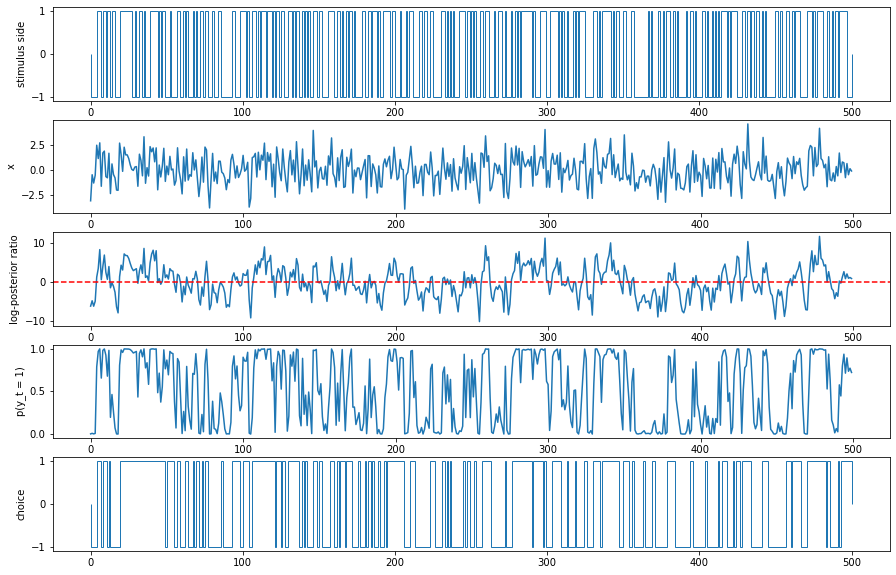

In [6]:
idx = np.s_[0:500]

(fig, ax) = plt.subplots(5, 1, figsize=(15, 10))

ax[0].stairs(s[idx])
ax[0].set_ylabel('stimulus side')

ax[1].plot(x[idx])
ax[1].set_ylabel('x')

ax[2].plot(r[idx])
ax[2].axhline(y=0, color='r', linestyle='--')
ax[2].set_ylabel('log-posterior ratio')

ax[3].plot(p[idx])
ax[3].set_ylabel('p(y_t = 1)')

ax[4].stairs(y[idx])
ax[4].set_ylabel('choice')

## Recover model parameters from prediction data

In [7]:
# Fit model to preductions from optimal model
model = GlazeModel()
model.fit(x, y)

In [8]:
# Print parameters of fit model
print(f'hazard_rate: {model.h} (agent: {h_agent})')
print(f'w_0: {model.w_0} (agent: {w0_true})')
print(f'w_1: {model.w_1} (agent: {w1_true})')

hazard_rate: 0.019181255992041745 (agent: 0.02)
w_0: 0.0003884472029596108 (agent: 0)
w_1: 2.0273871768870864 (agent: 2.0)


## Fit GLM-HMM to behavioral data

### Create GLM-HMM and fit to data

In [9]:
# Modify inputs and choice arrays for input into GLM-HMM
x_mod = np.ones((x.shape[0], 2))
x_mod[:, 0] = x
y_mod = np.reshape(y, (-1, 1))
y_mod = (y_mod + 1) / 2
y_mod = y_mod.astype(np.int64)

In [10]:
# Set the parameters of the GLM-HMM
num_states = 3
obs_dim = 1
num_categories = 2
input_dim = 2

# Create GLM-HMM
glm_hmm = ssm.HMM(
    num_states, 
    obs_dim, 
    input_dim, 
    observations="input_driven_obs", 
    observation_kwargs=dict(C=num_categories), 
    transitions="standard"
)

In [11]:
# Number of EM iterations
n_iter = 200

# Fit model
glm_hmm_fit = glm_hmm.fit(
    [y_mod], 
    inputs=[x_mod], 
    method="em", 
    num_iters=n_iter, 
    tolerance=10**-4
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [12]:
print('state 0:')
print(glm_hmm.observations.params[0])
print('state 1:')
print(glm_hmm.observations.params[1])
print('state 2:')
print(glm_hmm.observations.params[2])

state 0:
[[-1.76602719  2.76807539]]
state 1:
[[-1.29323841 -0.11806479]]
state 2:
[[-1.9961516  -2.71011046]]


### Plot most likely state sequence against decision function

In [13]:
est_states = glm_hmm.most_likely_states(y_mod, input=x_mod)

Text(0, 0.5, 'est. state')

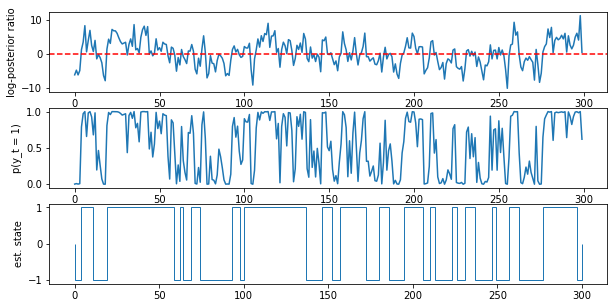

In [14]:
idx = np.s_[0:300]

(fig, ax) = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(r[idx])
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_ylabel('log-posterior ratio')

ax[1].plot(p[idx])
ax[1].set_ylabel('p(y_t = 1)')

ax[2].stairs(est_states[idx] - 1)
ax[2].set_ylabel('est. state')

In [15]:
p_corr = np.corrcoef(p, est_states)[0, 1]
print(f'correlation: {p_corr}')

correlation: 0.7224408199423995


### Plot most likely state sequence against prior

In [16]:
def phi(a, b):
    return np.logaddexp(0, a + b) - np.logaddexp(a, b)

r_prev = np.zeros(r.shape)
r_prev[1:] = r[:-1]
prior = phi(r_prev, logit(1 - h_agent))

Text(0, 0.5, 'GLM-HMM state')

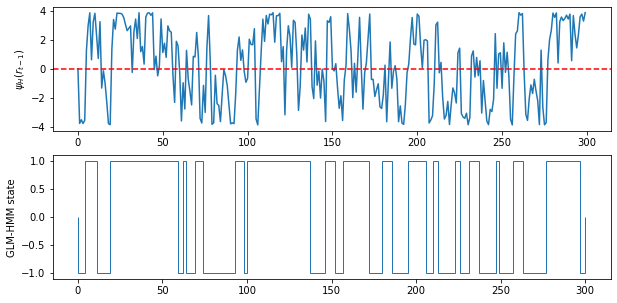

In [17]:
idx = np.s_[0:300]

(fig, ax) = plt.subplots(2, 1, figsize=(10, 5))

ax[0].plot(prior[idx])
ax[0].axhline(y=0, color='r', linestyle='--')
ax[0].set_ylabel('$\psi_H(r_{t-1})$')

ax[1].stairs(est_states[idx] - 1)
ax[1].set_ylabel('GLM-HMM state')

In [18]:
prior_corr = np.corrcoef(prior, est_states)[0, 1]
print(f'correlation: {prior_corr}')

correlation: 0.6359586272516229
